In [1]:
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
# from envs.filtr_json_from_race import load_from_db
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, f1_score

MLP model

In [2]:
class RaceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(32,128), nn.ReLU(),
            nn.Linear(128,128), nn.ReLU()
        )
        self.cont_head = nn.Linear(128,12)             # ciągłe
        # cat_classes = [10, 3, 3, 3, 3, 3, 3, 3, 3]  # ostatnia dentSeverity ma 3 klasy (0–2) (9 elementów)
        # self.cat_heads = nn.ModuleList([nn.Linear(128, n_classes) for n_classes in cat_classes])
        self.scaler_X = None
        self.scaler_Y = None

    def forward(self, x):
        h = self.shared(x)
        cont = self.cont_head(h)
        # cats = [head(h) for head in self.cat_heads]
        return cont#, cats
    
    def scale_input(self, X_grouped,Y_grouped):
         # --- Continous and discrete feature indices ---
        cont_indices = [0,1,2,3,4,5,6,7,8,9,10,11]          # continuous
        # cat_indices  = [12,13,14,15,16,17,18,19]  # discrete

        # --- Scale continuous features ---
        all_X_cont = np.vstack([x[:, cont_indices] for x in X_grouped])
        all_Y_cont = np.vstack([y[:, cont_indices] for y in Y_grouped])
        self.scaler_X = StandardScaler().fit(all_X_cont)
        self.scaler_Y = StandardScaler().fit(all_Y_cont)

        # Scale X and Y for continuous features
        X_scaled_grouped = []
        Y_scaled_grouped = []
        for x_seq, y_seq in zip(X_grouped, Y_grouped):
            x_scaled = np.array(x_seq)
            x_scaled[:, cont_indices] = self.scaler_X.transform(x_seq[:, cont_indices])
            X_scaled_grouped.append(x_scaled)

            y_scaled = np.array(y_seq)
            y_scaled[:, cont_indices] = self.scaler_Y.transform(y_seq[:, cont_indices])
            Y_scaled_grouped.append(y_scaled)

        # Conversion to torch tensors
        X_t = [torch.tensor(x, dtype=torch.float32) for x in X_scaled_grouped]
        Y_cont_t = [torch.tensor(y[:, cont_indices], dtype=torch.float32) for y in Y_scaled_grouped]
        # Y_cat_t  = [[torch.tensor(y[:, idx], dtype=torch.long) for idx in cat_indices] for y in Y_grouped]

        return X_t, Y_cont_t
    # Y_cat_t
    

Load data

In [3]:
def load_data_from_db():
    
    """
    Load data so that each race is a separate sequence:
    X = [ [state1_race1, state2_race1, ...], [state1_race2, ...] ]
    Y = [ [next1_race1, next2_race1, ...], ... ]
    """
    conn = sqlite3.connect(
        "E:/pracadyp/Race-optimization-reinforcement-learning/data/db_states_for_regress/race_data_states.db"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT race_id, states_json FROM races ORDER BY race_id")
    rows = cursor.fetchall()
    conn.close()

    X_grouped, Y_grouped = [], []

    for race_id, states_json in rows:
        states = json.loads(states_json)

        X_seq, Y_seq = [], []
        for i in range(len(states) - 1):
            X_seq.append(states[i][:-2])
            Y_seq.append(states[i + 1][:-12])  # bez ostatnich 12 kolumn (pogoda)

        X_grouped.append(np.array(X_seq, dtype=float))
        Y_grouped.append(np.array(Y_seq, dtype=float))

    return X_grouped, Y_grouped

Training loop

Using device: cuda
Fold 1
Using device: cuda
Fold 2


C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must impl

Using device: cuda
Fold 3


C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must impl

Using device: cuda
Fold 4


C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must impl

Using device: cuda
Fold 5


C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must impl

Using device: cuda
Fold 6


C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must impl

Using device: cuda
Fold 7


C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must impl

Using device: cuda
Fold 8


C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_scaled = np.array(x_seq)
C:\Users\pawel\AppData\Local\Temp\ipykernel_107164\3652073105.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must impl

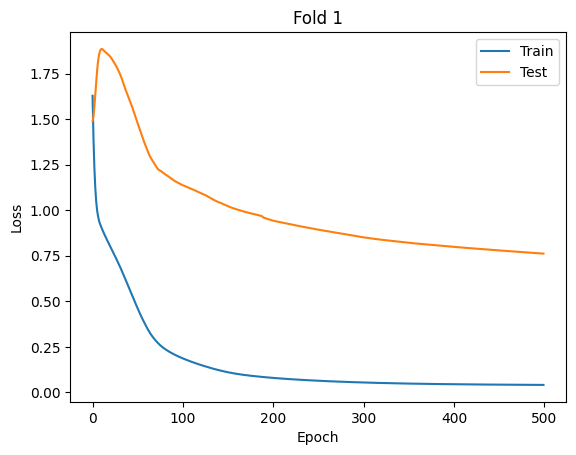

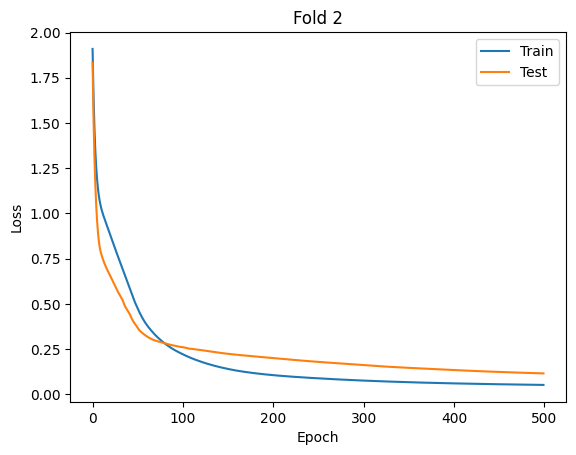

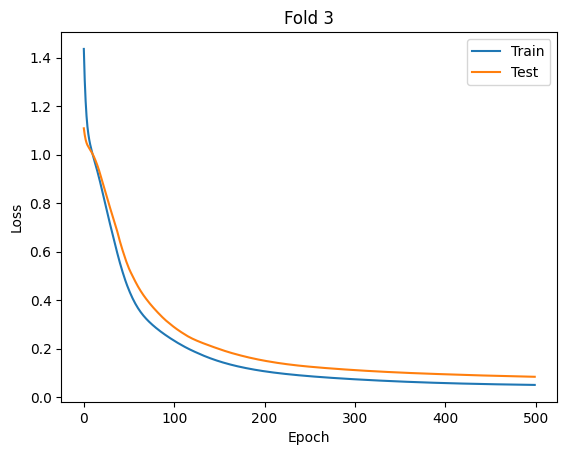

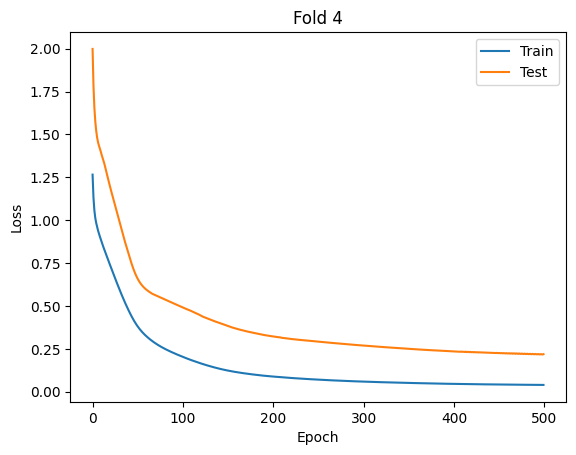

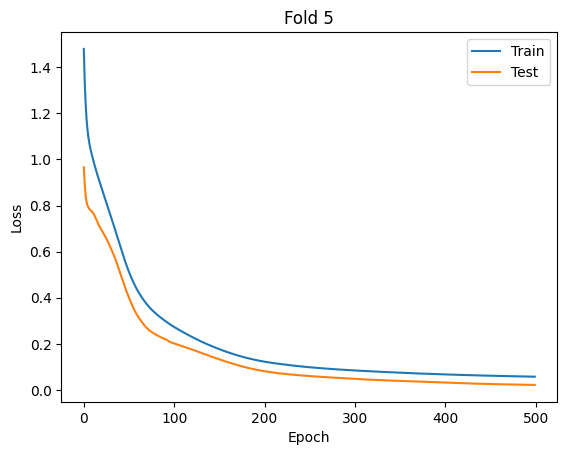

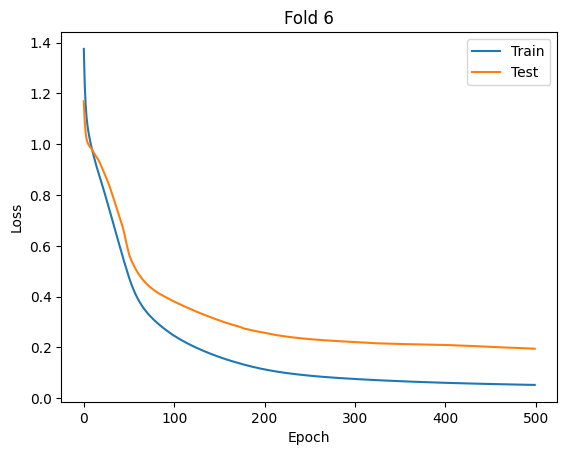

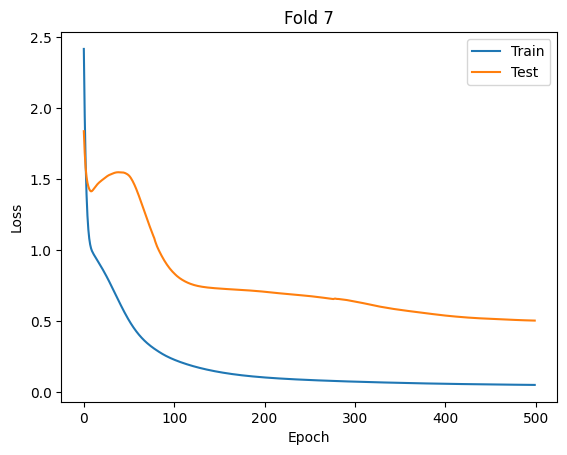

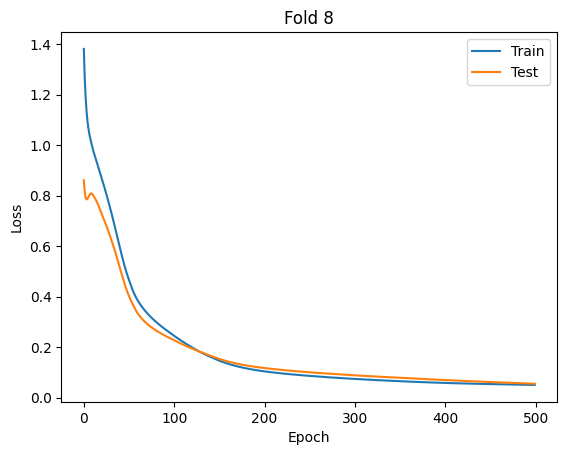

In [4]:
X, Y = load_data_from_db()

loo = LeaveOneOut()
all_fold_train = []
all_fold_test = []
for fold, (train_idx, test_idx) in enumerate(loo.split(X)):
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = RaceModel().to(device)

    X, Y_cont = model.scale_input(X, Y)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_cont = nn.MSELoss()
    loss_cat  = nn.CrossEntropyLoss()

    fold_train_losses = []
    fold_test_losses = []

    print(f"Fold {fold+1}")
    X_train = [X[i] for i in train_idx]
    X_test  = [X[i] for i in test_idx]
    Y_cont_train = [Y_cont[i] for i in train_idx]
    Y_cont_test  = [Y_cont[i] for i in test_idx]
    # Y_cat_train  = [Y_cat[i] for i in train_idx]
    # Y_cat_test   = [Y_cat[i] for i in test_idx]


# X_train, Y_cont_train, Y_cat_train = X[:2], Y_cont[:2], Y_cat[:2]  # dwa pierwsze wyścigi do treningu
# X_test, Y_cont_test, Y_cat_test   = X[2:], Y_cont[2:], Y_cat[2:]

    X_train = [x.to(device) for x in X_train]
    Y_cont_train = [y.to(device) for y in Y_cont_train]
    # Y_cat_train = [[y.to(device) for y in y_seq] for y_seq in Y_cat_train]

    X_test = [x.to(device) for x in X_test]
    Y_cont_test = [y.to(device) for y in Y_cont_test]   
    # Y_cat_test = [[y.to(device) for y in y_seq] for y_seq in Y_cat_test]
    
    n_epochs = 500
    for epoch in range(n_epochs):
        total_loss = 0.0
        model.train()
        for x_seq, y_cont_seq in zip(X_train, Y_cont_train): # y_cat_seq, Y_cat_train):
            # print(x_seq, y_cont_seq, y_cat_seq)
            optimizer.zero_grad()

            cont_pred = model(x_seq) # continuous and list of categorical predictions , cat_preds

            loss = loss_cont(cont_pred, y_cont_seq)
            # loss_k = sum(loss_cat(cat_pred, y_cat) for cat_pred, y_cat in zip(cat_preds, y_cat_seq))
            # loss = loss_c + loss_k
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(X_train)

        total_test_loss = 0.0
        model.eval()
        all_mse = []


        with torch.no_grad():
            for x_seq, y_cont_seq in zip(X_test, Y_cont_test): #,y_cat_seq, Y_cat_test):
                x_seq = x_seq.to(device)
                y_cont_seq = y_cont_seq.to(device)
                # y_cat_seq = [y.to(device) for y in y_cat_seq]

                cont_pred = model(x_seq) #, cat_preds = model(x_seq)

                loss = loss_cont(cont_pred, y_cont_seq)

                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(X_test)
        # print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
        
        fold_train_losses.append(avg_train_loss)
        fold_test_losses.append(avg_test_loss)
    
    all_fold_train.append(fold_train_losses)
    all_fold_test.append(fold_test_losses)

    # plt.plot(fold_train_losses, label=f'Fold {fold+1} Train', linestyle='-')
    # plt.plot(fold_test_losses,  label=f'Fold {fold+1} Test',  linestyle='--')

for fold in range(len(all_fold_train)):
    plt.figure()
    plt.plot(all_fold_train[fold], label='Train')
    plt.plot(all_fold_test[fold], label='Test')
    plt.title(f'Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



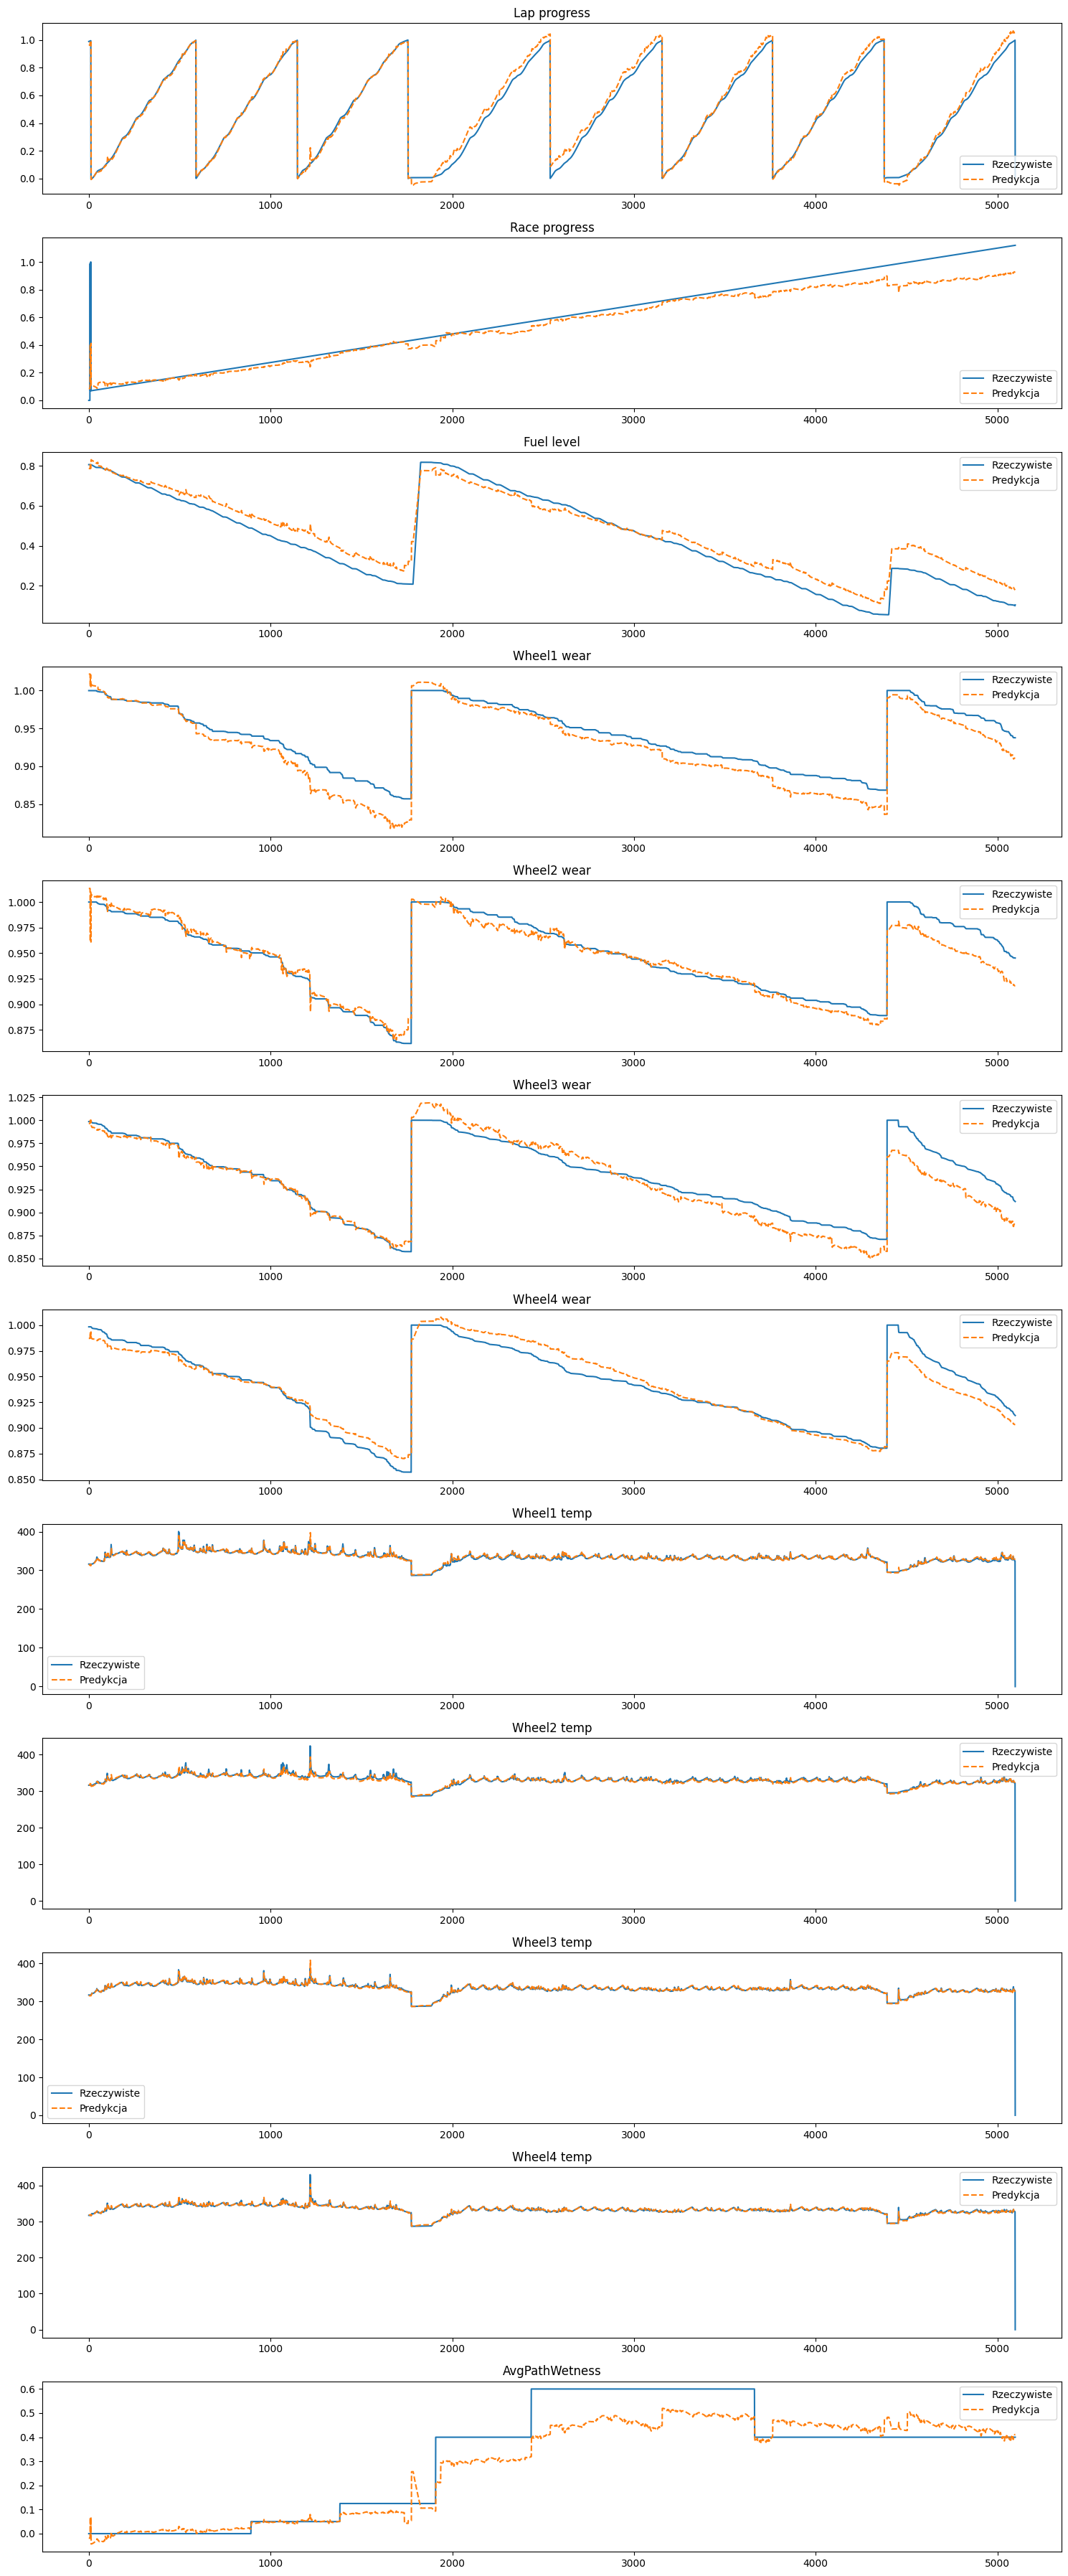

Test MSE (continuous): 9.0772


In [5]:
model.eval()
all_mse = []
# all_f1 = []

with torch.no_grad():
    for x_seq, y_cont_seq, in zip(X_test, Y_cont_test): #y_cat_seq , Y_cat_test):
        x_seq = x_seq.to(device)
        y_cont_seq = y_cont_seq.to(device)
        # y_cat_seq = [y.to(device) for y in y_cat_seq]

        cont_pred = model(x_seq) #, cat_preds = model(x_seq)

        # --- ciągłe ---
        # odskalowanie predykcji i prawdziwych wartości
        cont_pred_orig = torch.tensor(
            model.scaler_Y.inverse_transform(cont_pred.cpu().numpy())
        )
        y_cont_orig = torch.tensor(
            model.scaler_Y.inverse_transform(y_cont_seq.cpu().numpy())
        )

        mse = mean_squared_error(y_cont_orig.numpy(), cont_pred_orig.numpy())
        all_mse.append(mse)

        # --- kategoryczne ---
        # F1 dla każdej kategorii osobno i średnia mikro
        # f1s = []
        # for cat_pred, y_cat in zip(cat_preds, y_cat_seq):
        #     # pred_labels = torch.argmax(cat_pred, dim=1).cpu().numpy()
        #     true_labels = y_cat.cpu().numpy()
        #     f1 = f1_score(true_labels, pred_labels, average='micro')  # lub 'macro'
        #     f1s.append(f1)
        # all_f1.append(sum(f1s)/len(f1s))

avg_mse = sum(all_mse)/len(all_mse)
# avg_f1 = sum(all_f1)/len(all_f1)

num_features = y_cont_orig.shape[1]
plt.figure(figsize=(15, 3 * num_features))
titles = ['Lap progress','Race progress', 'Fuel level', 'Wheel1 wear', 'Wheel2 wear', 'Wheel3 wear', 'Wheel4 wear', 'Wheel1 temp','Wheel2 temp','Wheel3 temp','Wheel4 temp','AvgPathWetness']
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(y_cont_orig[:, i], label='Rzeczywiste')
    plt.plot(cont_pred_orig[:, i], label='Predykcja', linestyle='--')
    plt.title(f'{titles[i]}')
    plt.legend()



plt.tight_layout()
plt.show()


print(f"Test MSE (continuous): {avg_mse:.4f}")
# print(f"Test F1-score (categorical): {avg_f1:.4f}")

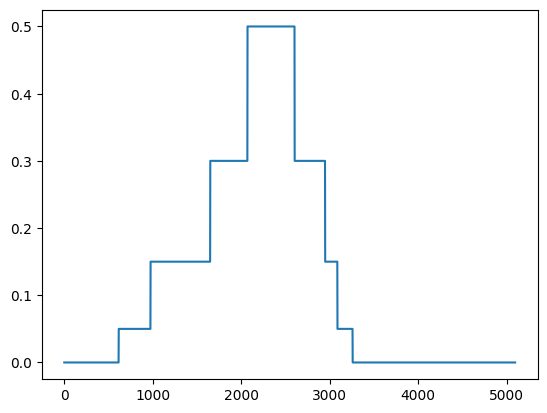

Done


In [6]:
X_test_org = X_test[0].cpu().numpy()
rain = []
for state in X_test_org:
    rain.append(state[28])

plt.figure()
plt.plot(np.arange(len(rain)), rain)
plt.show()

print("Done")
